# Part I - Initial Analysis

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading the Data

In [3]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'eval.csv')

original_training_data = pd.read_csv('data/train.csv')
evaluation = pd.read_csv('data/eval.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
evaluation['email'] = evaluation['email'].str.lower()

original_training_data.head()

Downloading, this may take a few minutes.
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Downloading, this may take a few minutes.
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split

[train, test] = train_test_split(original_training_data, test_size=0.1, random_state=42)

In [5]:
first_ham = train.loc[train['spam'] == 0, 'email'].iloc[0]
first_spam = train.loc[train['spam'] == 1, 'email'].iloc[0]

In [6]:
first_ham

'while i was playing with the past issues, it annoyed me that there was\n no easy way to make the log stop growing (i don\'t mean to truncate it,\n i mean to just freeze it for a while).\n \n the following patch adds a new button to the log window, which allows\n the log to be switched on/off (the button says "disable" when the\n log is enabled, and the button disables it, and "enable" when the log\n is frozen, and the button enables it again).\n \n kre\n \n --- main.tcl\twed aug 21 15:01:48 2002\n +++ /usr/local/lib/exmh-2.5/main.tcl\twed aug 28 17:36:59 2002\n @@ -385,6 +385,9 @@\n  \texmhlogcreate\n  \twm withdraw $exmh(logtop)\n      }\n +    if {! $exmh(logwrite)} {\n +\treturn\n +    }\n      if [info exists exmh(log)] {\n  \tcatch {\n  #\t    $exmh(log) insert end " [bw_delta] "\n @@ -407,6 +410,9 @@\n      set exmh(logwindow) 1\n      exwin_toplevel .log "exmh log" log\n      set exmh(logtop) .log\n +    set exmh(logdisablebut) \\\n +\t[widget_addbut $exmh(logtop).but swap "dis

In [7]:
first_spam

'--===_secatt_000_1fuklemuttfusq\n content-type: text/plain; charset="us-ascii"\n content-transfer-encoding: quoted-printable\n \n aluko martin\n 23 victoriagarden city=2c\n lagos-nigeria=2e\n \n attn=2e\n \n \n we have an immediate business proposal that involves us$34=2c700=2c000\n which we will like to invest under your custody=2e please=2c do not\n hesitate\n to send me an email=2c so as to discuss with you the details of the\n transaction=2fthe\n terms and condition of sharing regarding the business=2e\n your urgent response will be highly appreciated and will swiftly\n bring us\n to the commencement of the transaction=2e we hope to conclude this\n transaction\n within 10-12 working days=2e do not forget to contact me on receipt of\n this\n mail=2e and please ensure to maintain absolute confidentiality with\n regard to\n this\n pending transaction=2e i urgently await your response=2e\n \n best regards=2c\n \n aluko martin=2e\n \n -- \n \n \n --===_secatt_000_1fuklemuttfusq\n conte

### Feature Engineering

In [8]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = 1*np.array([texts.str.contains(word) for word in words]).T
    return indicator_array

### EDA

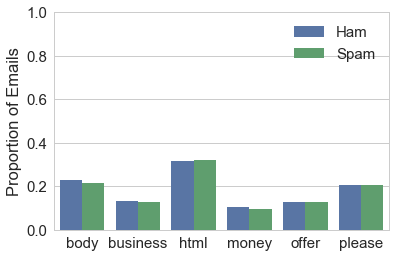

In [10]:
some_words = ['body', 'html', 'please', 'money', 'business', 'offer']
Phi_train = words_in_texts(some_words, train['email'])

df = pd.DataFrame(data = Phi_train, columns = some_words)
df['label'] = train['spam']

sns.barplot(x = "variable", 
            y = "value", 
            hue = "label", 
            data = (df
                    .replace({'label': 
                                {0 : 'Ham', 
                                 1 : 'Spam'}})
                    .melt('label')
                    .groupby(['label', 'variable'])
                    .mean()
                    .reset_index()))

plt.ylim([0, 1])
plt.xlabel('')
plt.ylabel('Proportion of Emails')
plt.legend(title = "")
plt.show()

/Users/josh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/josh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


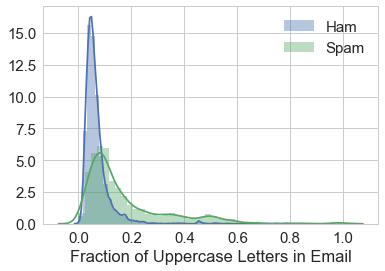

In [12]:
Train = pd.read_csv('../data/train.csv')
Train['frac_upper'] = (
    Train['email'].str.findall('[A-Z]').apply(len) / 
    Train['email'].str.findall('[a-zA-Z]').apply(len)
)

tmp = Train[['spam', 'frac_upper']]
sns.distplot(tmp.loc[tmp['spam'] == 0, 'frac_upper'])
sns.distplot(tmp.loc[tmp['spam'] == 1, 'frac_upper'])
plt.legend(['Ham', 'Spam'])
plt.xlabel('Fraction of Uppercase Letters in Email')
plt.show()

In [13]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

Phi_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

Phi_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), array([0, 0, 0, 0, 0]))

In [14]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(Phi_train, Y_train)

training_accuracy = model.score(Phi_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [15]:
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train == 1)

zero_predictor_acc = np.mean(Y_train == 0)
zero_predictor_recall = 0

Y_train_hat = model.predict(Phi_train)

TP = sum((Y_train_hat == Y_train) & (Y_train_hat == 1))
TN = sum((Y_train_hat == Y_train) & (Y_train_hat == 0))
FP = sum((Y_train_hat != Y_train) & (Y_train_hat == 1))
FN = sum((Y_train_hat != Y_train) & (Y_train_hat == 0))

logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP / (TP + FN)
logistic_predictor_far = FP / (FP + TN)

In [17]:
from sklearn.metrics import precision_recall_curve


accuracy:  0.9245308132570211


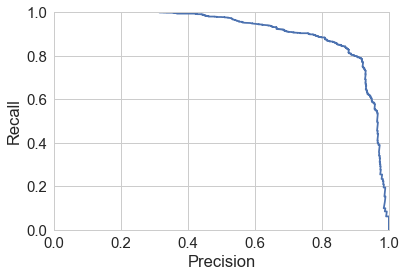

In [18]:
staff_words = ['body', 'click', 'please', 'base64', '2002', 'html', 'subscribed',
               'wrote', 'mortgage', 'align3dcenterfont', 'dear', 'br', 'width10img',
               'divfont', 'im', 'receive', 'list', 'tags', 'web', 'base64', 'click',
               'body', 'please', 'money', 'offer', 'receive', 'contact', 'free',
               'tr', 'removed', 'remove', 'html', 'font', 'form',
               'credit', 'business', 'div']

Phi_train = words_in_texts(staff_words, train['email'])

staff_model = LogisticRegression()
staff_model.fit(Phi_train, Y_train)

print('accuracy: ', staff_model.score(Phi_train, Y_train))

Y_predict = staff_model.predict_proba(Phi_train)[:, 1]
prec, recall, _ = precision_recall_curve(Y_train, Y_predict)
plt.plot(prec, recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()